In [2]:
# pip install transformers

In [2]:
import pandas as pd
import numpy as np
import matplotlib as plt
import os
import torch
from transformers import BertTokenizer, BertModel
%matplotlib inline

# Testing Embedding Conversion on Random Phrases 

In [16]:
df = pd.read_csv('random_phrases.csv', encoding = 'latin-1')

In [17]:
df.style

,Phrases
0,It's difficult to understand the lengths he'd go to remain short.
1,"As he waited for the shower to warm, he noticed that he could hear water change temperature."
2,"She hadn't had her cup of coffee, and that made things all the worse."
3,He would only survive if he kept the fire going and he could hear thunder in the distance.
4,"Car safety systems have come a long way, but he was out to prove they could be outsmarted."
5,"Thigh-high in the water, the fisherman's hope for dinner soon turned to despair."
6,His thought process was on so many levels that he gave himself a phobia of heights.
7,The beauty of the African sunset disguised the danger lurking nearby.
8,She wondered what his eyes were saying beneath his mirrored sunglasses.
9,His mind was blown that there was nothing in space except space itself.


# Use huggingface Transformers library and Pytorch to covnert to embeddings

In [34]:
# Let's encode some text in a sequence of hidden-states using each model:

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

# Show Tokenization

In [43]:
tokens = []

for i in df.Phrases:
    a = tokenizer.tokenize(i)
    tokens.append(a)

In [45]:
tokens[0]

['It',
 "'",
 's',
 'difficult',
 'to',
 'understand',
 'the',
 'lengths',
 'he',
 "'",
 'd',
 'go',
 'to',
 'remain',
 'short',
 '.']

# Next these tokenized sequences need to be encoded

In [103]:
embeds = []

for i in tokens:
    e = tokenizer.encode(i, add_special_tokens = True)
    embeds.append(torch.tensor(e))

In [104]:
test = embeds[0]
test

tensor([  101,  1135,   112,   188,  2846,  1106,  2437,  1103, 10707,  1119,
          112,   173,  1301,  1106,  3118,  1603,   119,   102])

# Embeddings Get Passed Through Model

In [105]:
model = BertModel.from_pretrained('bert-base-cased', output_hidden_states = True)

In [1]:
#We aren't training so this will improve performance
model.eval()

## For modeling, different features are needed beyond the encodings which will be type_ids and attention masks. These can be pulled out at same time using 'encode_plus'

## Tying this all together to loop over multiple entries

In [146]:
sent_list = []

for sent in df.Phrases:
    sent_list.append(tokenizer.encode_plus(sent, add_special_tokens = True))

In [151]:
out = []

# No grad call stops gradient calculation since we are not training but just passing information
with torch.no_grad():
    for item in sent_list:
        out.append(model(torch.tensor([item.input_ids]),torch.tensor([item.attention_mask])))

In [412]:
out[0]

(tensor([[[ 0.3241,  0.1901, -0.1976,  ..., -0.3044,  0.2508, -0.0703],
          [ 0.3889, -0.5495,  0.2118,  ..., -0.3423,  0.1257,  0.3257],
          [ 0.1388,  0.4705,  0.1219,  ..., -0.0422,  0.5497,  0.2824],
          ...,
          [ 0.3689,  0.2699,  0.0428,  ..., -0.2972,  0.0283,  0.1942],
          [ 0.9507,  0.7776, -0.1776,  ..., -0.2889,  0.3156, -0.8389],
          [ 0.8533,  0.7912, -0.1580,  ..., -0.2216,  0.3560, -0.7550]]]),
 tensor([[-6.2520e-01,  3.9674e-01,  9.9980e-01, -9.9363e-01,  9.7187e-01,
           9.3714e-01,  9.8965e-01, -9.9704e-01, -9.6729e-01, -6.6624e-01,
           9.8078e-01,  9.9889e-01, -9.9931e-01, -9.9967e-01,  9.4310e-01,
          -9.7999e-01,  9.8868e-01, -5.6353e-01, -9.9995e-01, -9.0544e-01,
          -6.2580e-01, -9.9983e-01,  9.8256e-02,  9.8656e-01,  9.8114e-01,
           4.4137e-02,  9.8770e-01,  9.9996e-01,  9.1355e-01, -6.9058e-01,
           2.4673e-01, -9.8856e-01,  9.0497e-01, -9.9834e-01,  2.2364e-02,
           1.9734e-01,  7

## Output Explained

__12-layer, 768-hidden, 12-heads, 110M parameters.__

- __The first [] pulls the information for a specific sentence__
- __The second [] is pulling the model output ... [0] gets last hidden layer ... [2] gets all the hidden layers__
- __The third [] will be zero just to remove extra list bracket__
- __The fourth [] returns the represenations for a specific word within the sentence all of these need to be rolled up__

In [182]:
out[0][2][-1]

tensor([[[ 0.3241,  0.1901, -0.1976,  ..., -0.3044,  0.2508, -0.0703],
         [ 0.3889, -0.5495,  0.2118,  ..., -0.3423,  0.1257,  0.3257],
         [ 0.1388,  0.4705,  0.1219,  ..., -0.0422,  0.5497,  0.2824],
         ...,
         [ 0.3689,  0.2699,  0.0428,  ..., -0.2972,  0.0283,  0.1942],
         [ 0.9507,  0.7776, -0.1776,  ..., -0.2889,  0.3156, -0.8389],
         [ 0.8533,  0.7912, -0.1580,  ..., -0.2216,  0.3560, -0.7550]]])

In [478]:
out[0][0]

tensor([[[ 0.3241,  0.1901, -0.1976,  ..., -0.3044,  0.2508, -0.0703],
         [ 0.3889, -0.5495,  0.2118,  ..., -0.3423,  0.1257,  0.3257],
         [ 0.1388,  0.4705,  0.1219,  ..., -0.0422,  0.5497,  0.2824],
         ...,
         [ 0.3689,  0.2699,  0.0428,  ..., -0.2972,  0.0283,  0.1942],
         [ 0.9507,  0.7776, -0.1776,  ..., -0.2889,  0.3156, -0.8389],
         [ 0.8533,  0.7912, -0.1580,  ..., -0.2216,  0.3560, -0.7550]]])

In [505]:
layers = []

for sentence in out:
    a = sentence
    layers.append(a[2])
    

## Start rolling up output layers as recommended to be represented

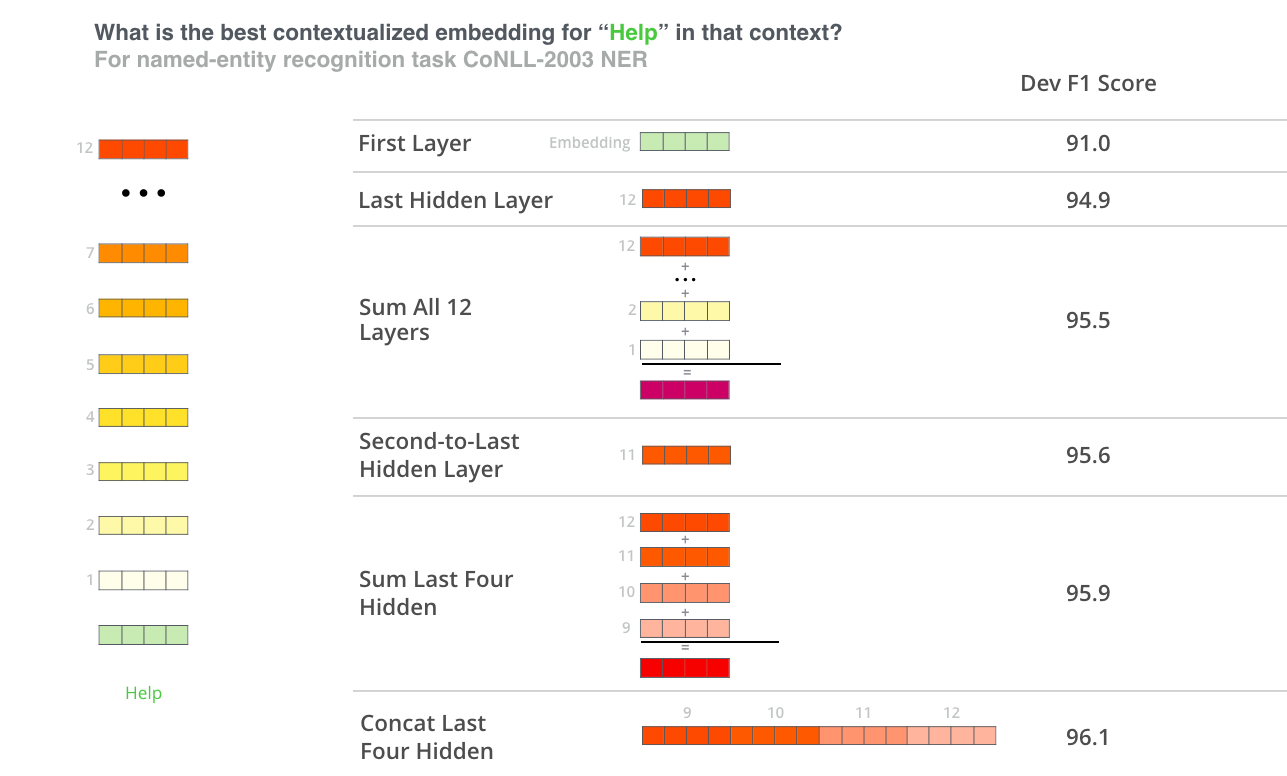

### __Since the output for each word is the 768 values from the hidden layer, we will just sum the last four layers to avoid having to model with too many inputs (768 * 4 when concating). After the layers are summed, we will average them to achieve the sentence level output. We will also grab the second to last hidden layer as it showed good results and is more simple to gather.__

## Second to last layer

In [594]:
stl = []

for sent in layers:
    temp = []
    a = sent[-2][0]

    for i in range(1,len(a)-1):
        temp.append(a[i])
        
    temp = torch.stack(temp)
    average = torch.mean(temp, dim = 0)
    stl.append(average)    

In [660]:
stl[0]

tensor([ 2.3301e-01,  1.6486e-01, -2.2901e-01, -2.3694e-01,  1.1153e-01,
         1.6810e-01,  3.9748e-01, -1.3793e-02,  1.2490e-01, -2.2441e-01,
         7.9992e-02,  2.1898e-01,  4.1090e-02,  3.9404e-01,  2.4642e-01,
        -1.6400e-01,  3.7095e-01, -2.5282e-01,  2.7853e-01, -4.8715e-02,
         1.9528e-01,  3.1423e-01,  4.7063e-01, -1.8626e-01, -6.8897e-02,
         1.4747e-01, -8.5298e-02,  2.9319e-01, -3.5173e-01,  3.4612e-01,
        -2.8540e-01,  2.9949e-01, -9.7806e-02,  2.3578e-01, -2.3027e-01,
         2.6187e-01, -1.2710e-01, -5.7467e-01, -1.4425e-01, -6.2530e-01,
        -1.9210e-01,  1.4263e-01, -1.1721e-01,  3.4553e-01,  3.7366e-01,
         2.6834e-01, -5.5064e-02,  1.9238e-01,  2.5594e-02, -4.0070e-01,
         1.8407e-01, -3.4912e-02,  2.9382e-02,  6.8338e-02,  3.0363e-01,
        -2.4241e-04, -2.7353e-01,  3.2847e-01, -1.3051e-01,  5.9830e-01,
        -2.9884e-01,  2.4846e-01,  3.8793e-01, -1.1263e-01,  2.6744e-01,
         7.0012e-02, -7.5666e-02,  2.0797e-01,  1.2

## Sum Last Four

In [ ]:
summed_last_4_layers = torch.stack(encoded_layers[-4:]).sum(0)

In [654]:
sl4 = []

for sent in layers:
    temp = []
    a = torch.stack(sent[-4:]).sum(0)[0]
    
    for i in range(1,len(a)-1):
        temp.append(a[i])
    
    temp = torch.stack(temp)
    average = torch.mean(temp, dim = 0)
    sl4.append(average)

In [702]:
sl4[9]

tensor([-1.0144e+00, -5.2454e-01, -1.6142e-01, -6.4973e-01,  1.4756e+00,
         5.8102e-01, -4.5416e-01,  1.0514e+00,  4.3956e-01,  5.0973e-01,
        -7.1671e-01,  1.9313e+00,  1.0115e+00,  1.0782e+00, -2.5013e+00,
        -1.0114e+00,  1.2189e+00,  1.2969e+00, -8.8536e-01, -7.1436e-01,
         1.2184e+00,  3.1329e-01,  9.4659e-01, -4.0308e-01, -1.6681e+00,
         1.2970e-01,  5.1024e-01,  1.9621e+00, -5.7869e-01,  2.6145e+00,
         3.1271e-01,  1.7935e-01,  2.4131e+00, -6.2620e-01,  8.3332e-01,
         6.7893e-01, -9.9961e-01,  1.9980e+00,  7.8685e-01, -1.3483e+00,
         1.1938e+00,  3.6215e-01, -7.5411e-01,  2.5758e-01,  3.5733e-01,
         3.7011e-01,  6.5149e-01, -9.4121e-01,  4.5943e-01,  7.0087e-01,
         5.1710e-01,  9.7104e-01,  7.5987e-01,  1.5441e-01, -5.4920e-01,
        -1.8208e-02,  6.3319e-01, -2.1882e-01,  9.9089e-01,  1.9490e+00,
         1.7885e-02,  2.5799e+00,  1.0233e+00,  4.6061e-01,  5.7735e-01,
         4.6225e-01, -3.1855e-01,  1.3827e+00,  1.0

# Just need to setup train/test sets and model however desired using actual data

In [711]:
mod_df = pd.DataFrame(sl4).astype(float)
mod_df.insert(0, column = 'Text', value = df.Phrases)
mod_df.insert(1, column = 'Type', value = 'WE')

In [712]:
mod_df

,Text,Type,0,1,2,3,4,5,6,7,...,758,759,760,761,762,763,764,765,766,767
0,It's difficult to understand the lengths he'd ...,WE,0.779751,0.463859,-1.077339,-0.444047,1.092676,0.578188,1.016047,-0.175899,...,-0.465053,-0.375350,0.217992,1.234886,2.448724,2.094081,-0.027794,0.354875,-0.960346,0.856558
1,"As he waited for the shower to warm, he notice...",WE,0.518125,-0.451973,0.031158,0.219552,-0.081289,-0.725243,-2.442196,-0.369982,...,-0.869822,2.957144,0.210037,-0.527262,0.103630,-0.817914,1.473112,-0.156885,-0.377877,1.518425
2,"She hadn't had her cup of coffee, and that mad...",WE,-0.539996,0.397115,1.286446,1.129629,1.182055,-1.541052,0.496772,-0.102168,...,-1.660121,0.868636,-1.025013,0.464677,0.679336,0.206245,-0.230514,-0.368210,0.041995,0.435118
3,He would only survive if he kept the fire goin...,WE,0.374275,-0.210176,-0.130280,1.143175,-0.205650,1.401278,-0.570613,-0.699733,...,-0.440457,0.341022,-0.367665,-2.345187,0.287183,0.111930,1.835475,-0.010841,1.152818,0.009501
4,"Car safety systems have come a long way, but h...",WE,2.318152,-0.117783,-0.276603,-0.325514,0.789369,0.876710,0.694458,0.949763,...,0.751523,0.077025,-0.315259,-0.753496,1.814947,0.393204,0.557759,0.858110,-0.210355,-0.396362
5,"Thigh-high in the water, the fisherman's hope ...",WE,-2.035635,0.624270,0.002840,0.735095,-0.445517,-0.746429,-1.758533,-0.364582,...,-0.303138,1.441830,-1.607510,-1.082880,0.718783,0.415022,-1.570396,-0.909367,0.254326,0.975215
6,His thought process was on so many levels that...,WE,-0.166675,1.228272,-0.341451,-0.329376,1.605727,1.287688,0.022579,0.259486,...,-0.353859,-0.129783,-1.017377,-1.534938,0.913449,0.986670,-0.325879,0.485907,-0.282094,1.731229
7,The beauty of the African sunset disguised the...,WE,-0.482158,-0.830576,-0.321199,0.183615,0.293322,1.260046,0.018400,1.130800,...,0.951532,-0.412221,-1.065712,-1.454897,-0.413133,0.262133,-1.085583,-0.409519,0.455551,0.506798
8,She wondered what his eyes were saying beneath...,WE,-0.633242,0.494287,-0.071258,0.472556,0.765238,0.059299,0.833227,-0.550641,...,-0.706121,-0.043468,0.273298,0.662544,1.132228,1.107995,-0.959250,0.086180,2.175976,-0.002574
9,His mind was blown that there was nothing in s...,WE,-1.014395,-0.524544,-0.161416,-0.649734,1.475565,0.581016,-0.454156,1.051351,...,-0.449930,0.077927,-0.284302,-0.468678,1.210877,-0.169166,-0.929656,-0.397138,2.210522,0.337575


# Same Transformation on Actual Data

In [4]:
#Read in the actual Dataset
df = pd.read_csv(combined_weather_data.csv)

In [5]:
df.head().style

,text,location,screen_name,follower_count,retweets,favorites,verified,Type
0,RT @PressTV: UPDATE: Death toll from Iran’s quake rises to 200 #earthquake https://t.co/DklVc2VwKW,nan,hull_arturo,45,0,0,False,Earthquake
1,RT @CAFOD: We pray for all those affected by the earthquake in Iraq and Iran https://t.co/qja8zQSuQe,"Mill Hill, Blackburn",StAidanMillHill,129,0,0,False,Earthquake
2,RT @ReutersWorld: JUST IN: Death toll reaches 328 in Iran earthquake - ISNA news agency https://t.co/FgRLptfk9l,대한민국 인천광역시,ShayvsConnor18,256,0,0,False,Earthquake
3,"RT @LaylaAlhussein: A magnitude 7.2 earthquake struck northern Iraq in Erbil, Iraq, on November 12, 2017. #Iraq https://t.co/KSPmuNDPsk",Pakistan,sadiqshah2112,85,0,0,False,Earthquake
4,Video: 7.2-magnitude earthquake jolts #Iran-Iraq border area; structural damage reported https://t.co/Jeh1EXMiyq https://t.co/EmvW58Y6u4,nan,BehzadMoezi,6192,0,0,False,Earthquake


In [6]:
# Let's encode some text in a sequence of hidden-states using each model:

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [7]:
model = BertModel.from_pretrained('bert-base-cased', output_hidden_states = True)
#We aren't training so this will improve performance
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

# Perform Conversion and Obtain Model Output

In [8]:
sent_list = []

for sent in df.text:
    sent_list.append(tokenizer.encode_plus(sent, add_special_tokens = True))

In [1]:
out = []

# No grad call stops gradient calculation since we are not training but just passing information
with torch.no_grad():
    for item in sent_list:
        out.append(model(torch.tensor([item.input_ids]),torch.tensor([item.attention_mask])))

# Get hidden layer outputs

In [ ]:
layers = []

for sentence in out:
    a = sentence
    layers.append(a[2])

# Roll up Output
__Using the sum of the last four layers as it showed better results__

In [ ]:
sl4 = []

for sent in layers:
    temp = []
    a = torch.stack(sent[-4:]).sum(0)[0]
    
    for i in range(1,len(a)-1):
        temp.append(a[i])
    
    temp = torch.stack(temp)
    average = torch.mean(temp, dim = 0)
    sl4.append(average)

# Get DataFrame Output to Easily Model

In [12]:
df.head(1).style

,text,location,screen_name,follower_count,retweets,favorites,verified,Type
0,RT @PressTV: UPDATE: Death toll from Iran’s quake rises to 200 #earthquake https://t.co/DklVc2VwKW,nan,hull_arturo,45,0,0,False,Earthquake


In [15]:
mod_df = pd.DataFrame(sl4).astype(float)
mod_df.insert(0, column = 'text', value = df.text)
mod_df.insert(1, column = 'type', value = df.Type)
mod_df.insert(2, column = 'follower_count', value = df.follower_count)
mod_df.insert(3, column = 'verified', value = df.verified)

## Example of Resulting Data Set

In [5]:
ex.head()

,text,type,follower_count,verified,0,1,2,3,4,5,...,758,759,760,761,762,763,764,765,766,767
0,RT @PressTV: UPDATE:\nDeath toll from Iran’s q...,Earthquake,45,False,-0.180702,-0.557254,-0.257066,0.247704,-0.116079,-1.246596,...,-1.880393,0.574295,-1.082280,-1.194331,-0.716398,-1.528029,-1.393145,1.733719,0.871081,3.009707
1,RT @CAFOD: We pray for all those affected by t...,Earthquake,129,False,0.332884,-1.345755,-0.410285,0.575408,-0.032268,-1.802706,...,-1.687065,0.718519,-1.029724,-0.767176,-0.032971,-1.298846,-1.810065,1.686207,0.579394,2.899038
2,RT @ReutersWorld: JUST IN: Death toll reaches ...,Earthquake,256,False,-0.339567,-1.182502,-0.533709,0.414308,-0.113260,-2.112401,...,-1.734978,0.265315,-0.387211,-1.872770,-0.245966,-2.044150,-1.692681,1.304106,1.558600,3.291314
3,RT @LaylaAlhussein: A magnitude 7.2 earthquake...,Earthquake,85,False,1.150446,-0.266334,-0.942941,0.596258,-0.945368,-1.232079,...,-1.013363,0.537306,-0.347581,-0.786124,-0.903818,-0.866392,-1.320476,1.485271,0.290309,1.867713
4,Video: 7.2-magnitude earthquake jolts #Iran-Ir...,Earthquake,6192,False,0.868155,-1.257778,0.021792,0.602206,-1.028045,-1.127659,...,-1.190339,0.817445,-1.245844,-1.677243,-0.206908,-1.712536,-1.538209,0.461534,0.934861,2.520552
